### Conway-Maxwell-Poisson distribution

I came across a distribution recently for {inter,over}-dispersion and heavy tail count data. The [Conway-Maxwell-Poisson distribution](https://en.wikipedia.org/wiki/Conway%E2%80%93Maxwell%E2%80%93Poisson_distribution).

I think may be it can model the count data for this challenge better. In this notebook, the implementation of the log partition function is an approximation and the implementation of the random number gnerator follow the implementation in the package [Numerics](https://github.com/mathnet/mathnet-numerics/blob/master/src/Numerics/Distributions/ConwayMaxwellPoisson.cs) in C#.

In [1]:
#import os
#import sys

#pymc3_path = os.path.join(os.environ["HOME"], "repos", "lib", "pymc3")
#sys.path.insert(0, pymc3_path)

In [2]:
%matplotlib inline

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.distributions.discrete import Discrete, bound, draw_values, generate_samples

theano.config.compute_test_value = "ignore"

sns.set_context("talk")
sns.set_style("darkgrid")
sns.set_palette("Set2", 20)
figsize(8, 6)

In [3]:
sales = pd.read_csv("data/sales.csv")
sales.describe()

,sales_unit
count,3012.000000
mean,7.583997
std,20.489378
min,0.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,444.000000


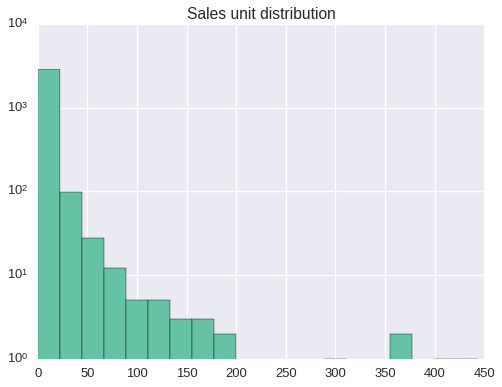

In [4]:
sales.sales_unit.hist(bins=20, log=True)
plt.title("Sales unit distribution")

### A COM-Poisson model

In [5]:
class CMPoisson(Discrete):
    def __init__(self, lamda, nu, *args, **kwargs):
        super(CMPoisson, self).__init__(*args, **kwargs)
        self.lamda = lamda
        self.alpha = tt.power(lamda, 1/nu)
        self.nu = nu
    
    def logp(self, value):
        nu = self.nu
        alpha = self.alpha
        pi = tt.constant(np.pi)
        
        Z = tt.exp(nu * alpha) / (tt.power(2 * pi * alpha, (nu-1)/2) * tt.sqrt(nu))
        return bound(value * tt.log(lamda) - nu * tt.gammaln(value+1) - tt.log(Z), lamda >= 0, nu >= 0)
    
    def _random(self, lamda, nu, size=None):
        size = size or 1
        nu = np.atleast_1d(nu)
        alpha = np.atleast_1d(np.power(lamda, 1/nu))
        Z = np.exp(nu * alpha) / ((2 * np.pi * alpha)**((nu-1)/2) * np.sqrt(nu))
        #log_Z = nu * alpha - ((nu-1)/2)*np.log(2*np.pi*alpha) - 0.5*np.log(nu)
        
        U = np.random.uniform(low=0, high=1, size=size)
        values = np.empty(size, dtype=int)
        
        for i in range(size):
            p = 1/Z
            cdf = p
            k = 0
            u = U[i]
            
            while u > cdf:
                k += 1
                p =  (p * lamda)/k**nu
                cdf += p
            
            values[i] = k
        return values
    
    def random(self, point=None, size=None, repeat=None):
        lamda,nu = draw_values([self.lamda, self.nu], point=point)
        return generate_samples(self._random, lamda, nu, dist_shape=self.shape, size=size)

In [6]:
CMPoisson.dist(lamda=2.3, nu=1.3).random(size=10)

array([3, 0, 1, 2, 3, 2, 3, 0, 3, 2])

In [7]:
pm.Poisson.dist(mu=2.3).random(size=10)

array([2, 2, 2, 4, 3, 1, 1, 5, 2, 5])

In [9]:
cmp_model = pm.Model()

with cmp_model:
    lamda = pm.Gamma("lamda", alpha=2, beta=2)
    nu = pm.HalfNormal("nu", sd=10)
    
    like = CMPoisson("like", lamda=lamda, nu=nu, observed=sales.sales_unit)

Applied log-transform to lamda and added transformed lamda_log to model.
Applied log-transform to nu and added transformed nu_log to model.


In [10]:
with cmp_model:
    advi_fit = pm.advi(n=2000)

Iteration 0 [0%]: ELBO = -63698.03
Iteration 200 [10%]: Average ELBO = -676842.76
Iteration 400 [20%]: Average ELBO = -575542.69
Iteration 600 [30%]: Average ELBO = -510729.49
Iteration 800 [40%]: Average ELBO = -472502.74
Iteration 1000 [50%]: Average ELBO = -504737.06
Iteration 1200 [60%]: Average ELBO = -406780.96
Iteration 1400 [70%]: Average ELBO = -423821.78
Iteration 1600 [80%]: Average ELBO = -387605.11
Iteration 1800 [90%]: Average ELBO = -349661.63
Finished [100%]: Average ELBO = -321942.66


In [11]:
with cmp_model:
    trace_cmp = pm.sample_vp(advi_fit, draws=500)

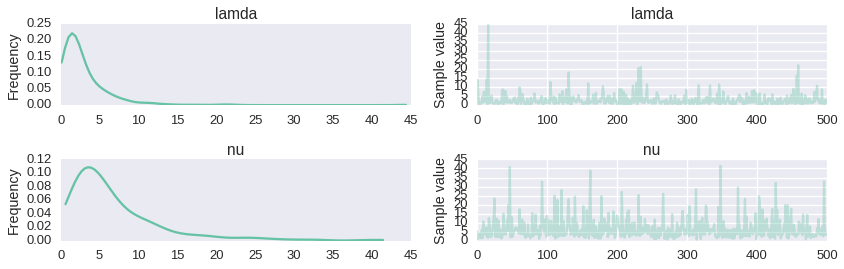

In [12]:
_ = pm.traceplot(trace_cmp)

In [ ]:
with cmp_model:
    cmp_ppc = pm.sample_ppc(trace_cmp, samples=10)

Galit Shmuel et al. [A useful distribution for fitting discrete data: revival of the Conway–Maxwell–Poisson distribution](www.galitshmueli.com/system/files/JRSS-COM-Poisson.pdf)

Burc ̧in S ̧ims ̧ek and Satish Iyengar [Approximating the Conway-Maxwell-Poisson normalizing constant](http://www.doiserbia.nb.rs/img/doi/0354-5180/2016/0354-51801604953S.pdf)

### A Poisson model

In [13]:
pois_model = pm.Model()

with pois_model:
    lamda = pm.Gamma("lamda", alpha=2, beta=2)
    
    like = pm.Poisson("like", mu=lamda, observed=sales.sales_unit)

Applied log-transform to lamda and added transformed lamda_log to model.


In [14]:
with pois_model:
    advi_fit = pm.advi(n=2000)

Iteration 0 [0%]: ELBO = -89194.94
Iteration 200 [10%]: Average ELBO = -52712.59
Iteration 400 [20%]: Average ELBO = -52758.77
Iteration 600 [30%]: Average ELBO = -53960.15
Iteration 800 [40%]: Average ELBO = -52277.52
Iteration 1000 [50%]: Average ELBO = -49198.87
Iteration 1200 [60%]: Average ELBO = -49158.71
Iteration 1400 [70%]: Average ELBO = -47551.4
Iteration 1600 [80%]: Average ELBO = -48883.32
Iteration 1800 [90%]: Average ELBO = -47076.54
Finished [100%]: Average ELBO = -46194.27


In [15]:
with pois_model:
    trace_pois = pm.sample_vp(advi_fit, draws=500)

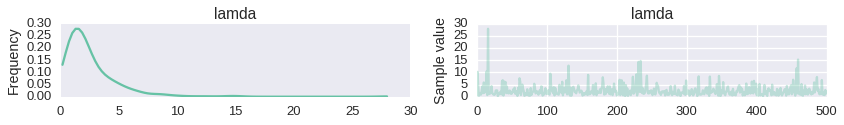

In [16]:
_ = pm.traceplot(trace_pois)

In [ ]:
with pois_model:
    pois_ppc = pm.sample_ppc(trace_pois, samples=10)